In [1]:
# !pip install yfinance
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.pyplot as plt
import tensorflow 
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import LeakyReLU

In [2]:
nsdq_ticks = "data/nasdaqlisted.txt"
nyse_ticks = "data/companylist.csv"
nyse = pd.read_csv(nyse_ticks)
nsdq = pd.read_csv(nsdq_ticks,sep="|")
nyse_tickers = nyse['Symbol']
nsdq_tickers = nsdq['Symbol']
all_tickers = nyse_tickers.append(nsdq_tickers)
print("Length of Total Tickers:",len(list(all_tickers)))
list(all_tickers)
all_tickers = ['JPM','BAC','MS','GS','CS','UBS','EV','UNM','WFC','KEY','PFG','WTS','HBAN','VONG','VONV','TFC','STT']

Length of Total Tickers: 5493


In [3]:
def corr(X):
    X_new = X.iloc[:-1].T
    X_new.dropna(inplace = True)
    corr = X_new.T.corr(method ='pearson')
    return corr,X_new

In [4]:
def corr_stocks(corr,X_new,corr_min=.8,corr_max=.92):
    connections = []
    positions = zip(*np.where((corr >= corr_min) & (corr <= corr_max)))
    for i,j in positions:
        if i == j:
            pass
        if (X_new.iloc[[i,j]].index[1],X_new.iloc[[i,j]].index[0]) in connections:
            pass
        else:
            connections.append((X_new.iloc[[i,j]].index[0],X_new.iloc[[i,j]].index[1]))
    return connections

In [5]:
def pull_data(all_tickers,start_date='2012-01-01',end_date='2020-04-01'):
    X = pd.DataFrame()
    full_data = pd.DataFrame()
    for tick in all_tickers:
        data = yf.download('{}'.format(tick),start_date,end_date)
        full_data['Open' + '_' + tick] = data['Open']
        full_data['High' + '_' + tick] = data['High']
        full_data['Low' + '_' + tick] = data['Low']
        full_data['Close' + '_' + tick] = data['Close']
        full_data['Volume' + '_' + tick] = data['Volume']
        full_data['Yesterday_Close' + '_' + tick] = full_data['Close' + '_' + tick].shift(-1)
        X['Close' + '_' + tick] = data['Close'] 
        X['Yesterday_Close' + '_' + tick] = X['Close' + '_' + tick].shift(-1)
        X['Delta Change' + '_' + tick] = X['Close' + '_' + tick] - X['Yesterday_Close' + '_' + tick]
        X[tick] = (X['Delta Change' + '_' + tick] / X['Yesterday_Close' + '_' + tick])*100
        X.drop(columns = ['Close' + '_' + tick], axis = 1, inplace = True)
        X.drop(columns = ['Yesterday_Close' + '_' + tick], axis = 1, inplace = True)
        X.drop(columns = ['Delta Change' + '_' + tick], axis = 1, inplace = True)
    return full_data, X

In [6]:
def new_df(df,stock1,stock2):
    stockdata1 = [col for col in df.columns if "_{}".format(stock1) in col]
    stockdata2 = [col for col in df.columns if "_{}".format(stock2) in col]
    result = pd.concat([df[stockdata1],df[stockdata2]],axis=1)
    result.dropna(inplace = True,axis=0)
    result['Relative_Price'] = result['Yesterday_Close_{}'.format(stock1)] / result['Yesterday_Close_{}'.format(stock2)] 
    result.drop(columns = ['Yesterday_Close_{}'.format(stock1)], axis = 1, inplace = True)
    result.drop(columns = ['Yesterday_Close_{}'.format(stock2)], axis = 1, inplace = True)
    return result

In [7]:
def view_relative_price(result,stock1,stock2):
    plt.plot(range(result.shape[0]),result['Relative_Price'])
    plt.title("Relative Price of stock {} and {}".format(stock1,stock2))
    plt.ylabel("Relative Price")
    plt.xlabel("Days")
    plt.show()

In [8]:
def conver_series(data,seq=1):
    frames = []
    for time in range(seq-1,-1,-1):
        col_names = []
        new_cols = data.shift(time)
        frames.append(new_cols)
        for i in new_cols.columns:
            col_names.append(i +  "(t-{})".format(time))
        frames[-1].columns = col_names
    
    X = pd.concat(frames,axis=1)
    X.dropna(inplace = True,axis=0)
    return X


In [9]:
def scaled(result):
    scaler = StandardScaler()
    scaled = pd.DataFrame(scaler.fit_transform(result.iloc[:,:-1]))
    scaled['Return_Deviation'] = np.array(result.iloc[:,-1])
    scaled.columns = result.columns
    return scaled

In [10]:
def split(scaled):
    train_set = int(.8 * scaled.shape[0])
    train = scaled.iloc[:train_set, :]
    test = scaled.iloc[train_set:, :]
    train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
    test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]
    val_set = int(.7 * train_X.shape[0])
    val_X = train_X[val_set:]
    val_y = train_y[val_set:]
    train_X = train_X[:val_set]
    train_y = train_y[:val_set]
    train_X = train_X.values.reshape((train_X.shape[0], 1,train_X.shape[1]))
    val_X = val_X.values.reshape((val_X.shape[0], 1,val_X.shape[1]))
    test_X = test_X.values.reshape((test_X.shape[0], 1,test_X.shape[1]))
    print(train_X.shape,val_X.shape,test_X.shape)
    return train_X, test_X, train_y, test_y, val_X,val_y,train_set,val_set

In [11]:
def fit(train_X,val_X,train_y,val_y,lr=.1):
    model = Sequential()
    model.add(LSTM(700, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(100)) 
    model.add(Dropout(0.1))
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('linear'))
    sgd = SGD(lr=lr)
    model.compile(loss='mae', optimizer=sgd)
    early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.001, patience=25, verbose=2, mode='auto', baseline=None, restore_best_weights=True)
    history = model.fit(train_X, np.array(train_y), epochs=epochs, batch_size=50,callbacks=[early], verbose = 0,validation_data=(val_X, np.array(val_y)), shuffle=False)
    print("Number of Parameters:",model.count_params())
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch Count")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()
    return model

In [12]:
def pred(test_X,model):
    yhat = model.predict(test_X)
    err = round(np.sum(np.sqrt((yhat - np.reshape(np.array(test_y),newshape=(-1,1)))**2))/yhat.shape[0],3)
    print("RMSE:",err)
    return err,yhat

In [13]:
def plot_pred(yhat,test_y,epochs,sequence):
    plt.plot(range(len(yhat)),test_y,label = 'actual')
    plt.plot(range(len(yhat)),yhat,label = 'predicted')
    plt.title('Error = {} with Epochs = {} and seq = {}'.format(err,epochs,sequence))
    plt.legend()
    plt.show()

In [14]:
def actions(row):
    if row['Predicted'] >= row['+3rd_Dev']:
        val = 1
    elif row['Predicted'] <= row['-3rd_Dev']:
        val = -1
    else:
        val = 0
    return val

In [15]:
def rolling(result, train_set,val_set,yhat,window=10): 
    testing = result.iloc[train_set:, :]
    mean = testing['Relative_Price(t-0)'].mean()
    std = testing['Relative_Price(t-0)'].std()
    testing['Predicted'] = yhat
    testing['MA'] = testing['Relative_Price(t-0)'].rolling(window=window).mean()
    testing['STD'] = testing['Relative_Price(t-0)'].rolling(window=window).std()
    testing['+3rd_Dev'] = testing['MA'] + (testing['STD'] *3)
    testing['-3rd_Dev'] = testing['MA'] - (testing['STD'] *3)
    testing.dropna(how = 'any',axis=0,inplace=True)
    testing['Action'] = testing.apply(actions, axis=1)
    print(testing['Action'].value_counts())
    return testing

In [16]:
def strategy(data, stock1='JPM',stock2='BAC',commission= 5,starting=10000):
    long_stock1 = False
    long_stock2 = False
    short_stock1 = False
    short_stock2 = False
    results = {}
    profit = 0
    invested = 0
    good_trade = 0
    bad_trade = 0
    for i,j in enumerate(data['Action']):
        try:
            if j == 1:
                if short_stock1 == False and long_stock2 == False:
                    short_stock1 = True
                    long_stock2 = True
                    results['short_{}_shares'.format(stock1)] = starting / data['Open_{}(t-0)'.format(stock1)][i+1]
                    results['long_{}_shares'.format(stock2)] = starting / data['Open_{}(t-0)'.format(stock2)][i+1]
                    results['short_{}_price'.format(stock1)] = data['Open_{}(t-0)'.format(stock1)][i+1]
                    results['long_{}_price'.format(stock2)] = data['Open_{}(t-0)'.format(stock2)][i+1]
                    profit -= commission * 2
                    invested += starting * 2
                else:
                    pass
            elif j ==0:
                if short_stock1 == True and long_stock2 == True:
                    profit -= (data['Close_{}(t-0)'.format(stock1)][i] - results['short_{}_price'.format(stock1)]) * results['short_{}_shares'.format(stock1)]
                    profit += (data['Close_{}(t-0)'.format(stock2)][i] - results['long_{}_price'.format(stock2)]) * results['long_{}_shares'.format(stock2)]
                    profit -= commission * 2
                    short_stock1 = False
                    long_stock2 = False
                    if -(data['Close_{}(t-0)'.format(stock1)][i] - results['short_{}_price'.format(stock1)]) * results['short_{}_shares'.format(stock1)] + (data['Close_{}(t-0)'.format(stock2)][i] - results['long_{}_price'.format(stock2)]) * results['long_{}_shares'.format(stock2)] >0:
                        good_trade +=1
                    elif -(data['Close_{}(t-0)'.format(stock1)][i] - results['short_{}_price'.format(stock1)]) * results['short_{}_shares'.format(stock1)] + (data['Close_{}(t-0)'.format(stock2)][i] - results['long_{}_price'.format(stock2)]) * results['long_{}_shares'.format(stock2)] < 0:
                        bad_trade +=1
    #                 
                elif long_stock1 == True and short_stock2 == True:  
                    profit += (data['Close_{}(t-0)'.format(stock1)][i] - results['long_{}_price'.format(stock1)]) * results['long_{}_shares'.format(stock1)]
                    profit -= (data['Close_{}(t-0)'.format(stock2)][i] - results['short_{}_price'.format(stock2)]) * results['short_{}_shares'.format(stock2)]
                    profit -= commission * 2
                    long_stock1 = False
                    short_stock2 = False
                    if (int(data['Close_{}(t-0)'.format(stock1)][i] - results['long_{}_price'.format(stock1)]) * results['long_{}_shares'.format(stock1)]) + -(int(data['Close_{}(t-0)'.format(stock2)][i] - results['short_{}_price'.format(stock2)]) * results['short_{}_shares'.format(stock2)])>0:
                        good_trade +=1
                    elif (int(data['Close_{}(t-0)'.format(stock1)][i] - results['long_{}_price'.format(stock1)]) * results['long_{}_shares'.format(stock1)]) + -(int(data['Close_{}(t-0)'.format(stock2)][i] - results['short_{}_price'.format(stock2)]) * results['short_{}_shares'.format(stock2)])<0:
                        bad_trade +=1  

                else: 
                    pass
            else:
                if long_stock1 == False and short_stock2 == False:
                    long_stock1 = True
                    short_stock2 = True
                    results['long_{}_shares'.format(stock1)] = starting / data['Open_{}(t-0)'.format(stock1)][i+1]
                    results['short_{}_shares'.format(stock2)] = starting / data['Open_{}(t-0)'.format(stock2)][i+1]
                    results['long_{}_price'.format(stock1)] = data['Open_{}(t-0)'.format(stock1)][i+1]
                    results['short_{}_price'.format(stock2)] =data['Open_{}(t-0)'.format(stock2)][i+1]
                    profit -= commission * 2
                    invested += starting *2
                else:
                    pass
        except:
            pass
    return profit, (((profit + invested) - invested) / invested+.00001) * 100,invested, good_trade / (good_trade + bad_trade+.00001),good_trade,bad_trade

In [17]:
def set_stocks(df,tick1,tick2):
    if df['Yesterday_Close_{}'.format(tick1)][0] >df['Yesterday_Close_{}'.format(tick2)][0]:
        stock1 = tick1
        stock2 = tick2
    else:
        stock1 =tick2
        stock2 =tick1
    return stock1,stock2

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

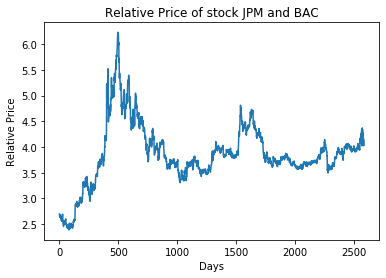

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Restoring model weights from the end of the best epoch.
Epoch 00072: early stopping
Number of Parameters: 2343021


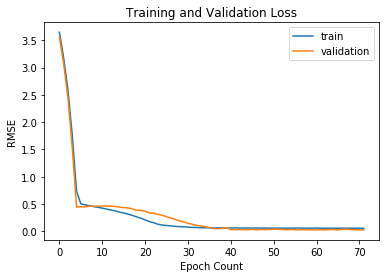

RMSE: 0.025


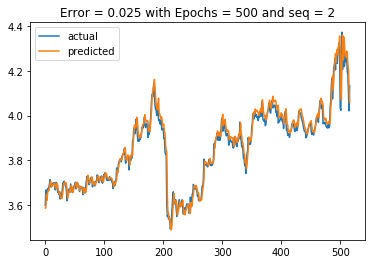

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

0    504
1      9
Name: Action, dtype: int64
Stock 1: JPM     Stock 2: BAC
profit: 45
Return %: 0.026037917163006373
trade_ratio: 0.89


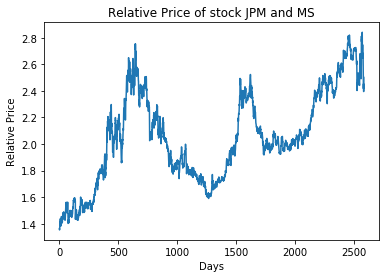

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00105: early stopping
Number of Parameters: 2343021


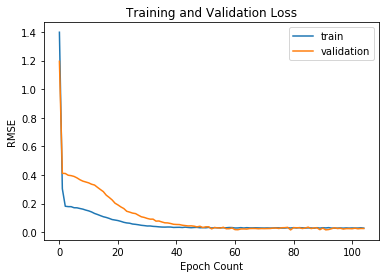

RMSE: 0.026


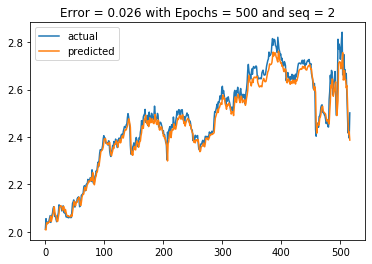

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

 0    480
-1     32
 1      1
Name: Action, dtype: int64
Stock 1: JPM     Stock 2: MS
profit: 282
Return %: 0.10179160862556558
trade_ratio: 0.86


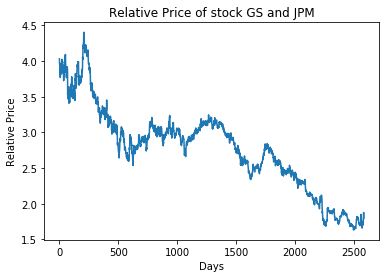

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping
Number of Parameters: 2343021


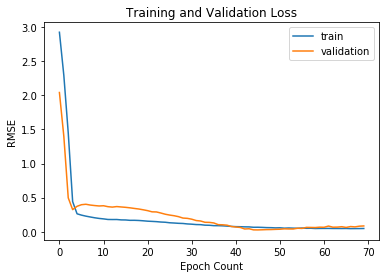

RMSE: 0.1


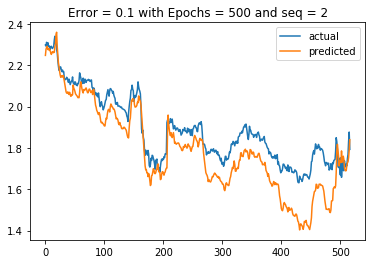

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

-1    412
 0    101
Name: Action, dtype: int64
Stock 1: GS     Stock 2: JPM
profit: -943
Return %: -0.2348781122256769
trade_ratio: 0.47


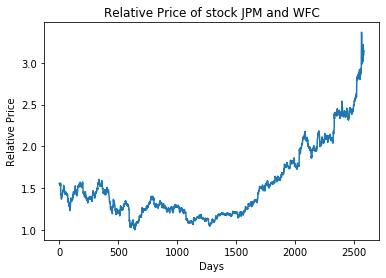

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00180: early stopping
Number of Parameters: 2343021


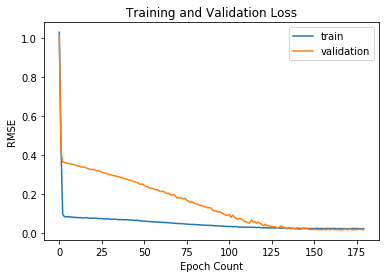

RMSE: 0.202


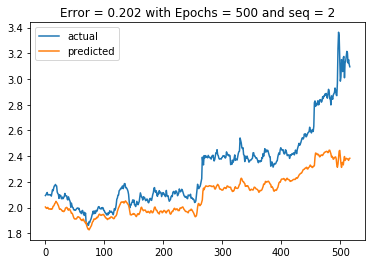

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

-1    478
 0     35
Name: Action, dtype: int64
Stock 1: JPM     Stock 2: WFC
profit: 1611
Return %: 0.7333260811691182
trade_ratio: 0.56


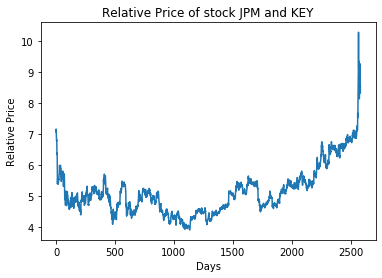

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00109: early stopping
Number of Parameters: 2343021


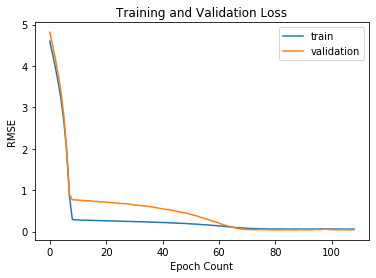

RMSE: 0.117


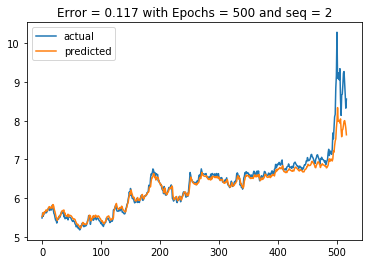

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

 0    450
-1     53
 1     10
Name: Action, dtype: int64
Stock 1: JPM     Stock 2: KEY
profit: -688
Return %: -0.11005133761480947
trade_ratio: 0.61


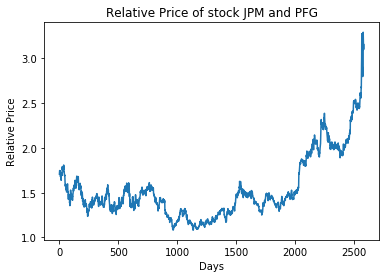

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Number of Parameters: 2343021


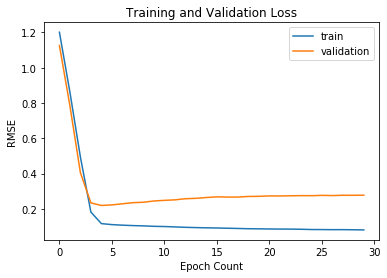

RMSE: 0.954


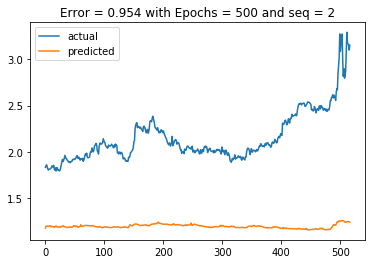

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

-1    513
Name: Action, dtype: int64
Stock 1: JPM     Stock 2: PFG
profit: -8
Return %: -0.039
trade_ratio: 0.0


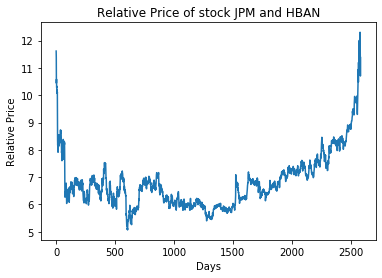

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00095: early stopping
Number of Parameters: 2343021


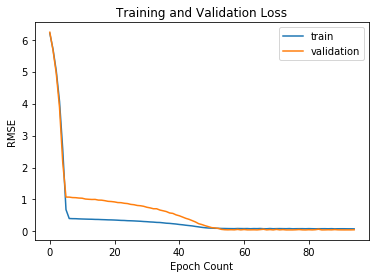

RMSE: 0.145


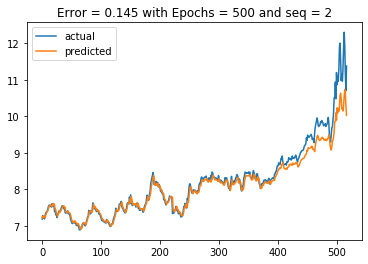

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

 0    450
-1     63
Name: Action, dtype: int64
Stock 1: JPM     Stock 2: HBAN
profit: 1380
Return %: 0.49395390093701175
trade_ratio: 0.57


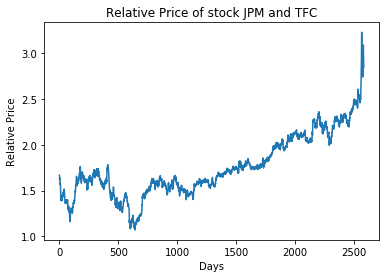

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00131: early stopping
Number of Parameters: 2343021


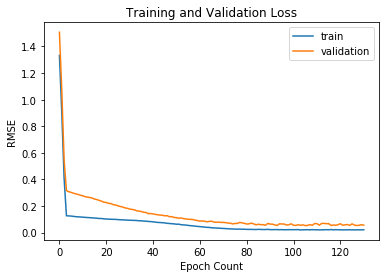

RMSE: 0.22


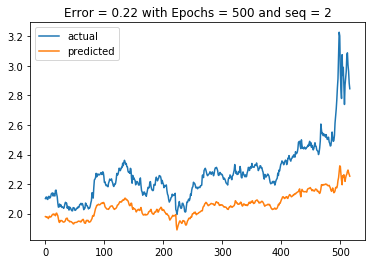

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

-1    502
 0     11
Name: Action, dtype: int64
Stock 1: JPM     Stock 2: TFC
profit: 138
Return %: 0.09964653459845743
trade_ratio: 0.5


C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


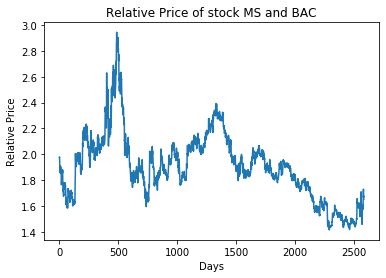

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Number of Parameters: 2343021


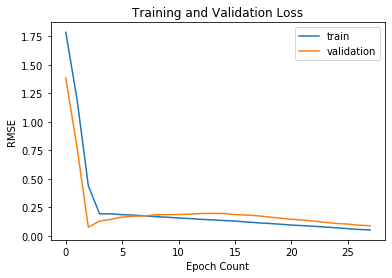

RMSE: 0.248


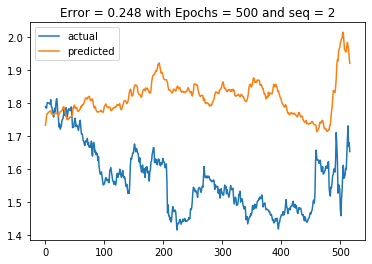

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

 1    469
 0     35
-1      9
Name: Action, dtype: int64
Stock 1: MS     Stock 2: BAC
profit: 340
Return %: 0.34176564746999066
trade_ratio: 0.5


C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


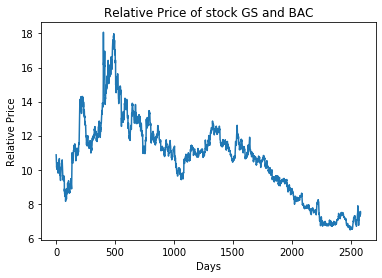

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
Number of Parameters: 2343021


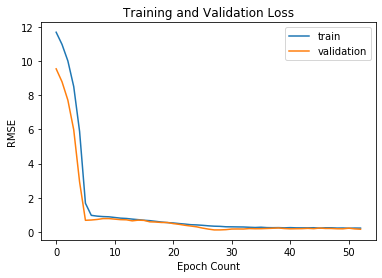

RMSE: 0.208


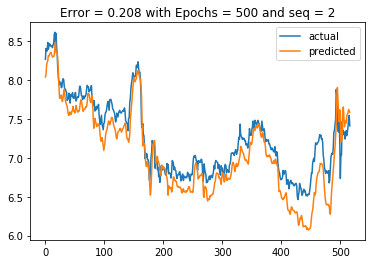

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

-1    307
 0    199
 1      7
Name: Action, dtype: int64
Stock 1: GS     Stock 2: BAC
profit: 595
Return %: 0.09712008834160084
trade_ratio: 0.58


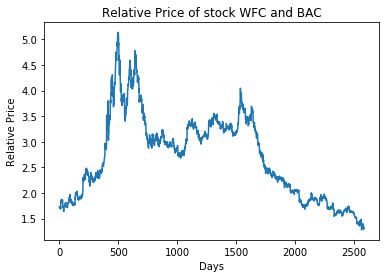

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Number of Parameters: 2343021


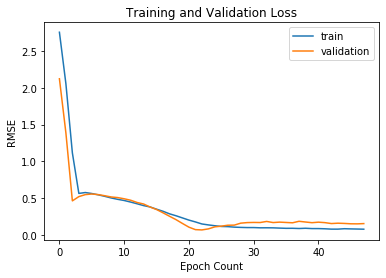

RMSE: 0.218


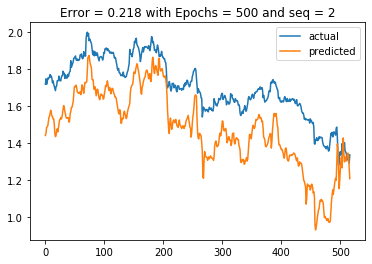

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

-1    490
 0     23
Name: Action, dtype: int64
Stock 1: WFC     Stock 2: BAC
profit: 14
Return %: 0.011522059007073818
trade_ratio: 0.4


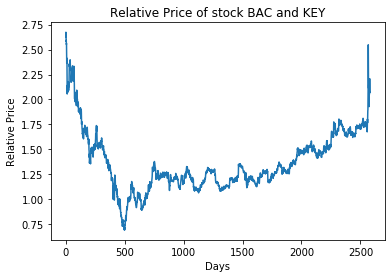

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping
Number of Parameters: 2343021


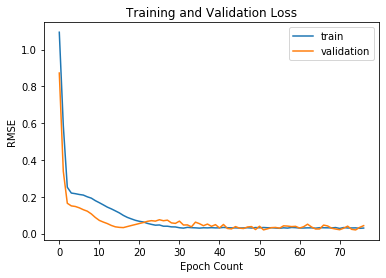

RMSE: 0.067


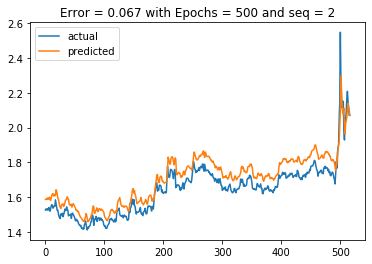

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

1    412
0    101
Name: Action, dtype: int64
Stock 1: BAC     Stock 2: KEY
profit: 1331
Return %: 0.23055472881616706
trade_ratio: 0.66


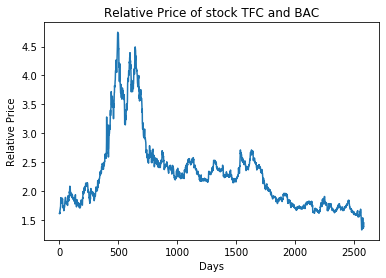

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Number of Parameters: 2343021


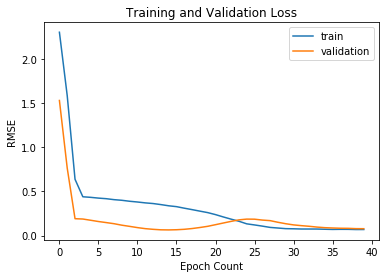

RMSE: 0.102


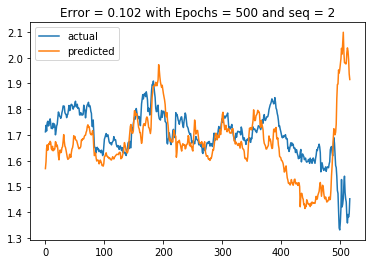

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

-1    305
 0    143
 1     65
Name: Action, dtype: int64
Stock 1: TFC     Stock 2: BAC
profit: -1241
Return %: -0.2376785692457208
trade_ratio: 0.39


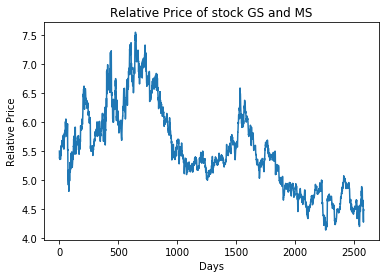

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00120: early stopping
Number of Parameters: 2343021


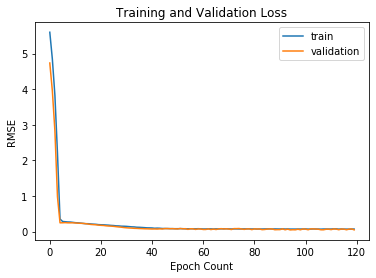

RMSE: 0.049


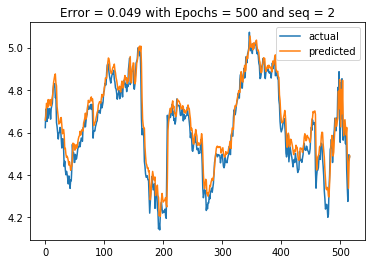

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

0    448
1     65
Name: Action, dtype: int64
Stock 1: GS     Stock 2: MS
profit: 597
Return %: 0.08634902527060227
trade_ratio: 0.66


C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


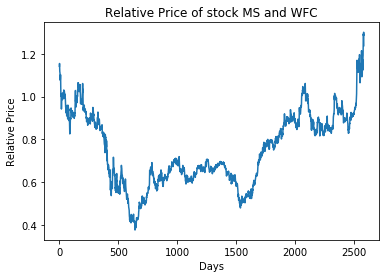

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Number of Parameters: 2343021


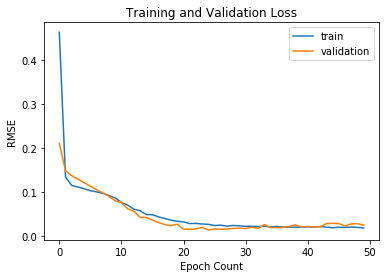

RMSE: 0.032


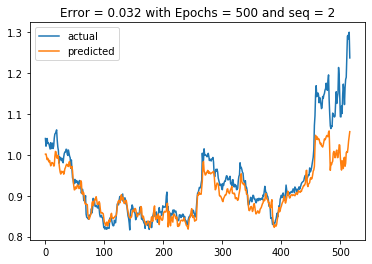

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

 0    311
-1    189
 1     13
Name: Action, dtype: int64
Stock 1: MS     Stock 2: WFC
profit: -782
Return %: -0.09003689021046468
trade_ratio: 0.67


C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


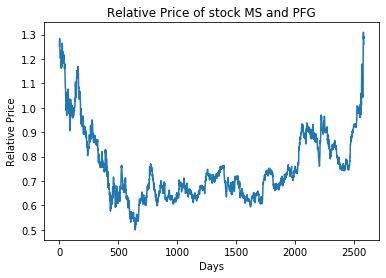

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
Number of Parameters: 2343021


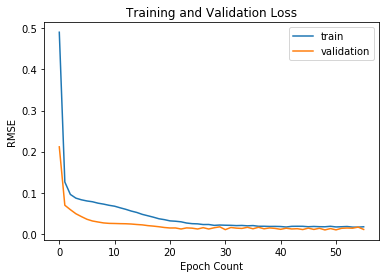

RMSE: 0.014


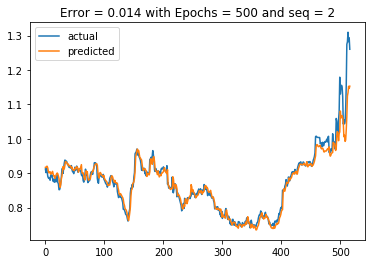

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

 0    477
-1     29
 1      7
Name: Action, dtype: int64
Stock 1: MS     Stock 2: PFG
profit: 305
Return %: 0.09631550689100185
trade_ratio: 0.44


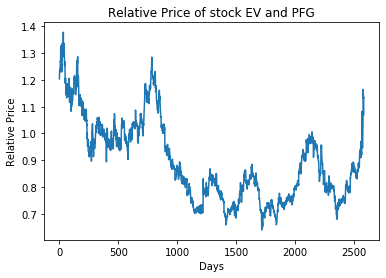

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00098: early stopping
Number of Parameters: 2343021


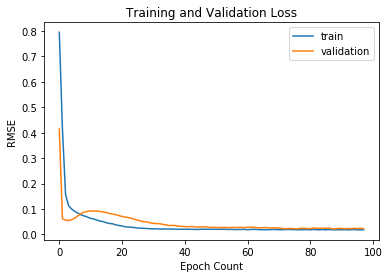

RMSE: 0.012


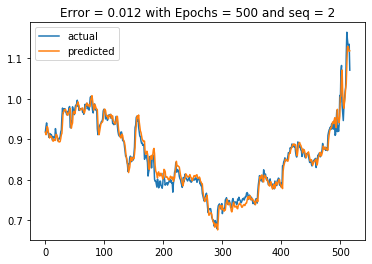

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

 0    488
 1     15
-1     10
Name: Action, dtype: int64
Stock 1: EV     Stock 2: PFG
profit: 440
Return %: 0.1583587797492967
trade_ratio: 0.89


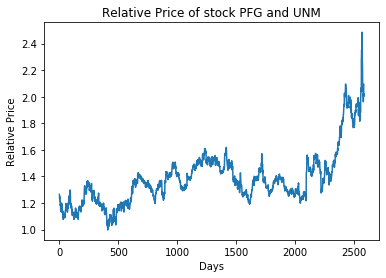

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Number of Parameters: 2343021


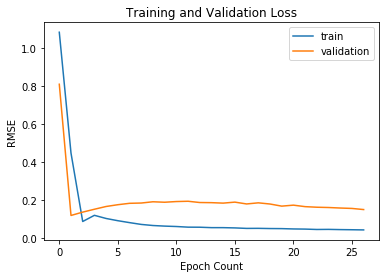

RMSE: 0.407


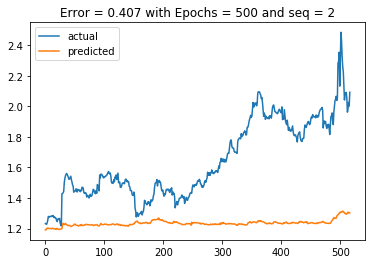

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

-1    498
 0     15
Name: Action, dtype: int64
Stock 1: PFG     Stock 2: UNM
profit: -659
Return %: -0.8233179907970444
trade_ratio: 0.33


C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


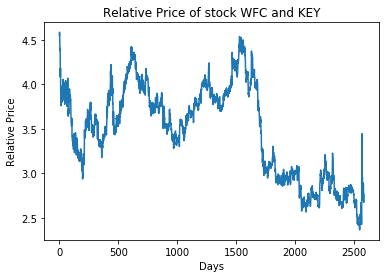

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00082: early stopping
Number of Parameters: 2343021


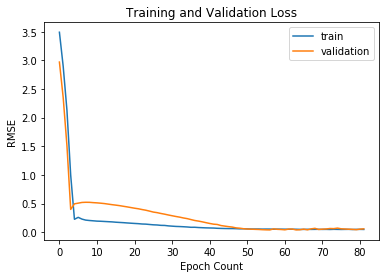

RMSE: 0.042


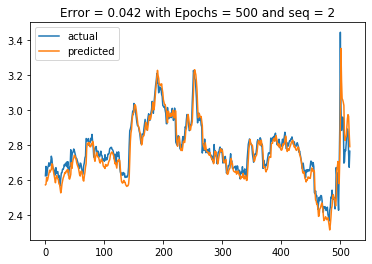

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

 0    464
-1     49
Name: Action, dtype: int64
Stock 1: WFC     Stock 2: KEY
profit: 794
Return %: 0.18154784235248173
trade_ratio: 0.67


C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


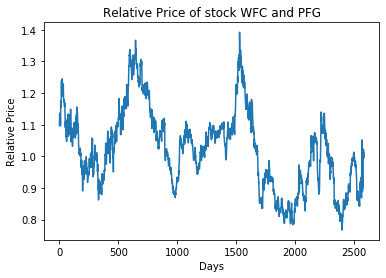

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping
Number of Parameters: 2343021


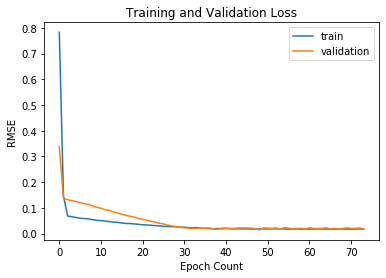

RMSE: 0.017


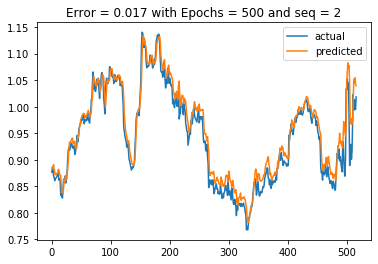

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

0    436
1     77
Name: Action, dtype: int64
Stock 1: WFC     Stock 2: PFG
profit: 1538
Return %: 0.22077064134137306
trade_ratio: 0.71


C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


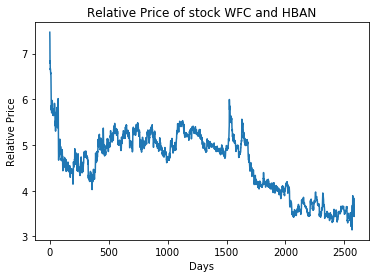

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
Number of Parameters: 2343021


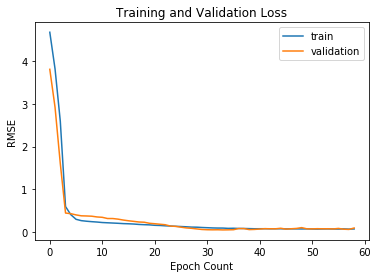

RMSE: 0.062


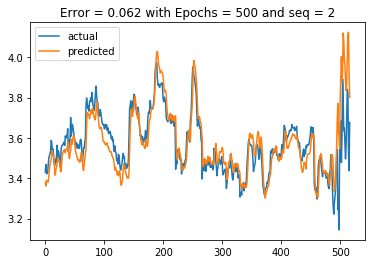

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

 0    419
-1     72
 1     22
Name: Action, dtype: int64
Stock 1: WFC     Stock 2: HBAN
profit: 402
Return %: 0.0703994155836669
trade_ratio: 0.59


C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


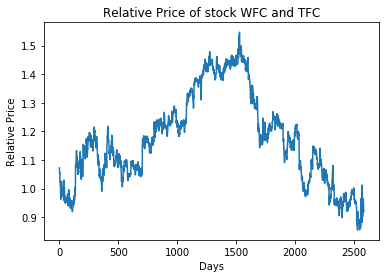

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00085: early stopping
Number of Parameters: 2343021


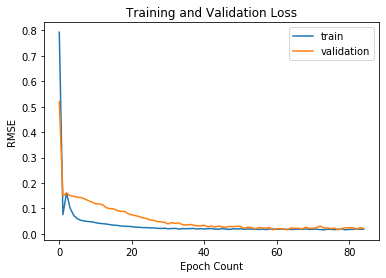

RMSE: 0.021


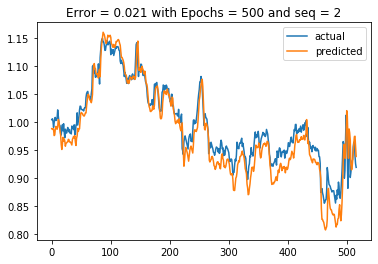

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

 0    317
-1    187
 1      9
Name: Action, dtype: int64
Stock 1: WFC     Stock 2: TFC
profit: 2171
Return %: 0.2422237587128378
trade_ratio: 0.71


C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


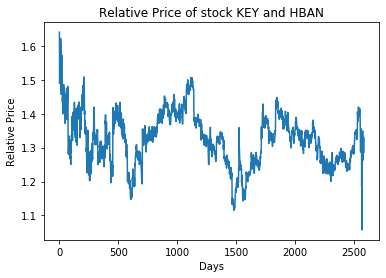

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00086: early stopping
Number of Parameters: 2343021


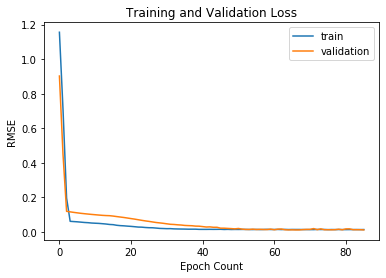

RMSE: 0.015


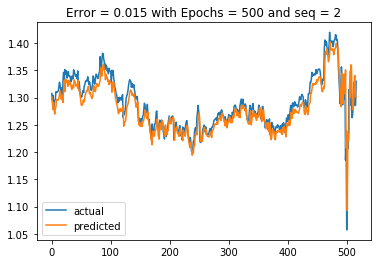

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

 0    421
-1     92
Name: Action, dtype: int64
Stock 1: KEY     Stock 2: HBAN
profit: 649
Return %: 0.09646684903868215
trade_ratio: 0.0


C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


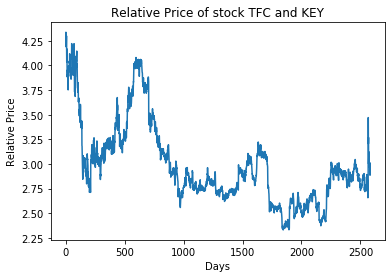

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
Number of Parameters: 2343021


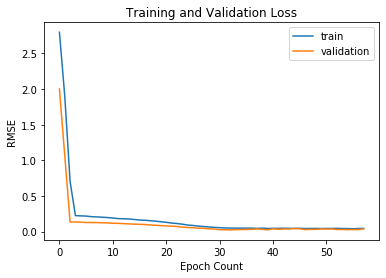

RMSE: 0.029


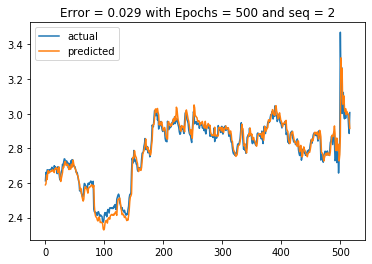

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

 0    474
-1     33
 1      6
Name: Action, dtype: int64
Stock 1: TFC     Stock 2: KEY
profit: -26
Return %: -0.006746322824455359
trade_ratio: 0.67


C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


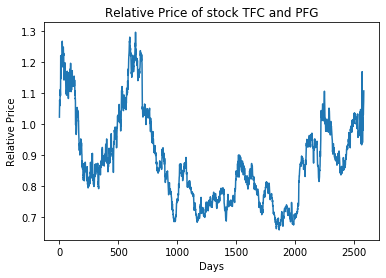

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00065: early stopping
Number of Parameters: 2343021


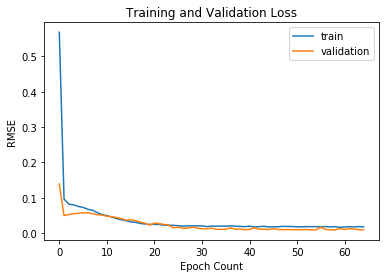

RMSE: 0.02


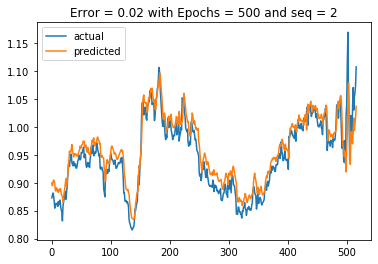

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

0    376
1    137
Name: Action, dtype: int64
Stock 1: TFC     Stock 2: PFG
profit: 757
Return %: 0.07521993254263905
trade_ratio: 0.63


C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


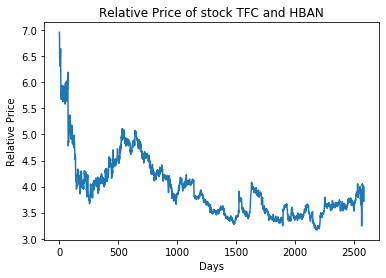

(2583, 22)
(1446, 1, 21) (620, 1, 21) (517, 1, 21)
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
Number of Parameters: 2343021


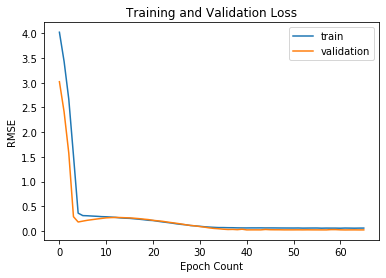

RMSE: 0.035


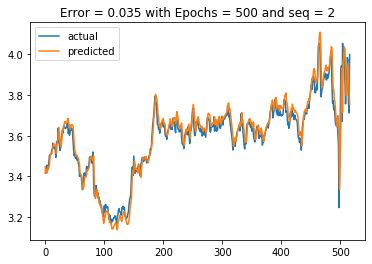

C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\grays\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

 0    485
-1     14
 1     14
Name: Action, dtype: int64
Stock 1: TFC     Stock 2: HBAN
profit: 127
Return %: 0.0363580350958186
trade_ratio: 0.54


,Stock Tickers,Profit,Positive Trade Ratio,ROI
0,"(JPM, WFC)",1611.117379,0.56,0.733326
1,"(JPM, HBAN)",1380.270923,0.57,0.493954
2,"(MS, BAC)",340.765647,0.50,0.341766
3,"(WFC, TFC)",2171.013828,0.71,0.242224
4,"(BAC, KEY)",1331.417427,0.66,0.230555
5,"(WFC, PFG)",1538.394489,0.71,0.220771
6,"(WFC, KEY)",794.410506,0.67,0.181548
7,"(EV, PFG)",440.604583,0.89,0.158359
8,"(JPM, MS)",282.216504,0.86,0.101792
9,"(JPM, TFC)",138.105148,0.50,0.099647


In [18]:
sequence = 2
epochs = 500
window = 5

full_data, X = pull_data(all_tickers[:-1],'2010-01-01','2020-04-11')
corr, X_new = corr(X)
connections = corr_stocks(corr,X_new,corr_min=.75,corr_max=.92)
profits = []
returns = []
stocks = []
ratios = []
for i in connections:
    stock1, stock2 = set_stocks(full_data,i[0],i[1])
    result = new_df(full_data,stock1,stock2)
    view_relative_price(result,stock1,stock2)
    result = conver_series(result,seq=sequence)    
    print(result.shape)
    scaled_data = scaled(result)
    train_X, test_X, train_y, test_y,val_X,val_y,train_set,val_set = split(scaled_data)
    model = fit(train_X,val_X,train_y,val_y,lr = .01)
    err,yhat = pred(test_X,model)
    plot_pred(yhat,test_y,epochs,sequence)
    data = rolling(result, train_set,val_set,yhat,window=window)
    profit, return_amount,invested, trade_ratio, goodtrade, badtrade = strategy(data,stock1,stock2, commission= 4,starting=10000)
    print("Stock 1:",stock1,"    Stock 2:",stock2)
    print("profit:",int(profit))
    print("Return %:",return_amount)
    print("trade_ratio:",round(trade_ratio,2))
    profits.append(profit)
    returns.append(return_amount)
    stocks.append((stock1,stock2))
    ratios.append(round(trade_ratio,2))
pd.DataFrame({"Stock Tickers":stocks,"Profit":profits,"Positive Trade Ratio":ratios,"ROI":returns}).sort_values(by='ROI',ascending = False).reset_index(drop = True)


In [19]:
# np.random.seed(1)
# gmm = GaussianMixture(n_components=350,covariance_type='full',reg_covar=1e-6,init_params = 'random',random_state=0)
# gmm.fit(X_scaled)

# clust = gmm.predict(X_scaled)
# distances = []
# allocated = []
# clusters = []
# for i in range(max(clust)):
#     items = np.sum(np.where(clust==i,1,0))
#     if items == 1:
#         pass
#     else:
#         clusters.append(i)
#         allocated.append(items)
#         distances.append(np.sum(np.sqrt((gmm.means_[i] - X_scaled[np.where(clust==i)])**2)) / items)

# allocated[np.argmin(distances)]
# np.where(np.array(allocated) == 2)[0][0]
# idx = np.where(np.array(allocated) == 3)[0][0]
# X_new.iloc[np.where(clust==idx)[0]]

# kmeans = KMeans(n_clusters=200, random_state=0).fit(X_scaled)
# clust = kmeans.predict(X_scaled)

# distances = []
# allocated = []
# for i in range(max(clust)):
#     items = np.sum(np.where(clust==i,1,0))
#     allocated.append(items)
#     distances.append(np.sum(np.sqrt((kmeans.cluster_centers_[i] - X_scaled[np.where(clust==i)])**2)) / items)
    